In [59]:
import time
import numpy as np
import pandas as pd
import timeit
import threading
import matplotlib.pyplot as plt

In [2]:
tasks = []

In [37]:
class CPU:

    def __init__(self,core_count=1,ram=2,vir_ram=200):
        #set cores
        self.cores = [Core(i) for i in range(core_count)]
        
        #set ram capacity
        self.ram = ram
        
        #set virtual ram capacity
        self.vir_ram = vir_ram
        
    #run cpu on global list tasks
    def run(self):
        t = []
        #set timer to calculate the time needed for this cpu to handle all tasks
        start = timeit.default_timer()
        def doWork(i):
            self.cores[i].run()
        
        #run all cores together!
        for i in range(len(self.cores)):
            thread = threading.Thread(target=doWork, args=(i,))
            t.append(thread)
            thread.start()

        #we need for cores to finish
        for thread in t:
            thread.join()
            
        #stop timer
        stop = timeit.default_timer()
        time = int((stop - start)*1000)*10**(-3)
        return time

In [42]:
class Core:
    id = None
    busy = None
    cur_task = None
    
    def __init__(self,id):
        self.id = id
        self.time_spend = 0
    
    def run(self):
        #print('i am core:',self.id)
        finished = False
        while(finished==False):
            finished = True
            for task in tasks:
                time.sleep(0.000001)
                #check if task is already done or not
                if(task.is_done()):continue
                finished = False
                #try solve one process of task
                prev_proc_lock = False
                for proc in task.process_queue:
                    if(proc.done):continue
                    #process is lock, so another core is working on it. we check next process 
                    if(proc.lock): prev_proc_lock = True; continue

                    #if we aren't in top of queue and we need prev proc to do this proc,
                    #so other core is working on it and we should wait for it's response.
                    #so we go to other task
                    if(proc.need_prev and prev_proc_lock): break

                    #else we run core on this process
                    proc.lock=True
                    time.sleep(proc.time*10**(-3))
                    self.time_spend+=proc.time*10**(-3)
                    proc.done = True
                    proc.lock = False
                    break #we break to do another task. we want to do tasks parallel

In [11]:
class Task:

    def __init__(self,id,proc_count,memory_needed=(0,0),time_needed=(0,1000),prev_prob=0):
        
        self.id = id
        
        #how many process this task had?
        self.proc_count = proc_count
        
        #create random process for this task
        self.process_queue = [Process(id,memory_needed,time_needed,prev_prob) for _ in range(proc_count)]
        
        #true if the task is done
        self.done = False
        
    #just a helper function to see that which core is working
    def state(self,core_id):
        print(f'core{core_id}:',end=' ')
        if(self.done):
            print(f'task {self.id} is completely done!')
            return
        c=0
        for proc in self.process_queue:
            if(proc.done):
                c+=1
                
        if(c*100/self.proc_count==100): print(f'task {self.id} is completely done!')
        else: print(f'task {self.id} is {int(c*100/self.proc_count)}% done.')
        
    #check if task is done
    def is_done(self):
        if(self.done):return True
        for proc in self.process_queue:
            if(proc.done==False):return False
        self.done = True
        return True

In [12]:
class Process:

    def __init__(self,task_id,memory_needed,time_needed,need_prev_prob):
        #the memory that this process is need(by byte)
        self.memory = create_random(*memory_needed)[0]
        
        #the time that this process need to be done(by second)
        self.time = create_random(*time_needed)[0]
        
        #this process blongs to which task?
        self.task_id = task_id
        
        #is this process lock?
        self.lock = False
        
        #if true, this process can't be done until all previous process in that task get done
        self.need_prev = np.random.choice([False,True],1,p=[1-need_prev_prob,need_prev_prob])
        
        #true when this process get done
        self.done = False

In [95]:
def create_random(Min,Max,RandomSize):
    RandomNumber = []
    power_rate = len(str(Max - Min))
    x_0 = int(time.time()*int(10e5))
    temp = RandomSize
    while(temp > 0):
        x_temp = ((19673528492*x_0 + 10041399)% 2**30)/2**30 * 10**power_rate
        if( Min <= x_temp <= Max):
            RandomNumber.append(int(x_temp))
            temp -= 1  
        x_0 = x_temp
    return RandomNumber

In [102]:
def runsTest(l, l_median):
    runs, n1, n2 = 0, 0, 0
    for i in range(len(l)):
        if (l[i] >= l_median and l[i-1] < l_median) or \
                (l[i] < l_median and l[i-1] >= l_median):
            runs += 1

        if(l[i]) >= l_median: n1 += 1
        else: n2 += 1

    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1)))
    z = (runs-runs_exp)/stan_dev
    return z

l = create_random(1,100,100000)
l_median= statistics.median(l)

Z = abs(runsTest(l, l_median))

if(Z>1.96):
    print('not random')
else:
    print('totally random!')
    


totally random!


In [25]:
#create tasks
#memory_needed: at most process have this memory(in byte)
#time_needed: at most process have this time to execute(in mili second)
def make_tasks(task_count=10,proc_count=20,time_range=(1,1000),prev_prob=0):
    tasks = [Task(i,proc_count,(0,1),time_range,prev_prob) for i in range(1,task_count)]
    s = 0
    for task in tasks:
        c=0
        for proc in task.process_queue:
            c+=proc.time*10**(-3)
        #print(c)
        s+=c
    #print(s)
    return (tasks,s)

,1core,2core,5core,10core,20core,50core,prev_prob,expected
0,9.640,4.842,2.014,1.014,0.552,0.336,0.0,7.591
1,9.625,5.025,2.102,1.167,0.783,0.826,0.1,7.595
2,9.616,4.990,2.184,1.405,0.954,0.925,0.2,7.613
3,9.592,4.857,2.319,1.308,1.219,1.158,0.3,7.616
4,9.654,5.007,2.304,1.530,1.567,1.964,0.4,7.613
5,9.591,5.088,2.537,1.554,1.527,1.556,0.5,7.587
6,9.611,4.903,2.634,2.152,1.927,1.704,0.6,7.598
7,9.522,5.049,2.491,2.181,2.032,2.181,0.7,7.609
8,9.562,5.312,2.598,2.314,2.314,2.109,0.8,7.591
9,9.516,5.329,2.800,2.466,2.319,2.419,0.9,7.589


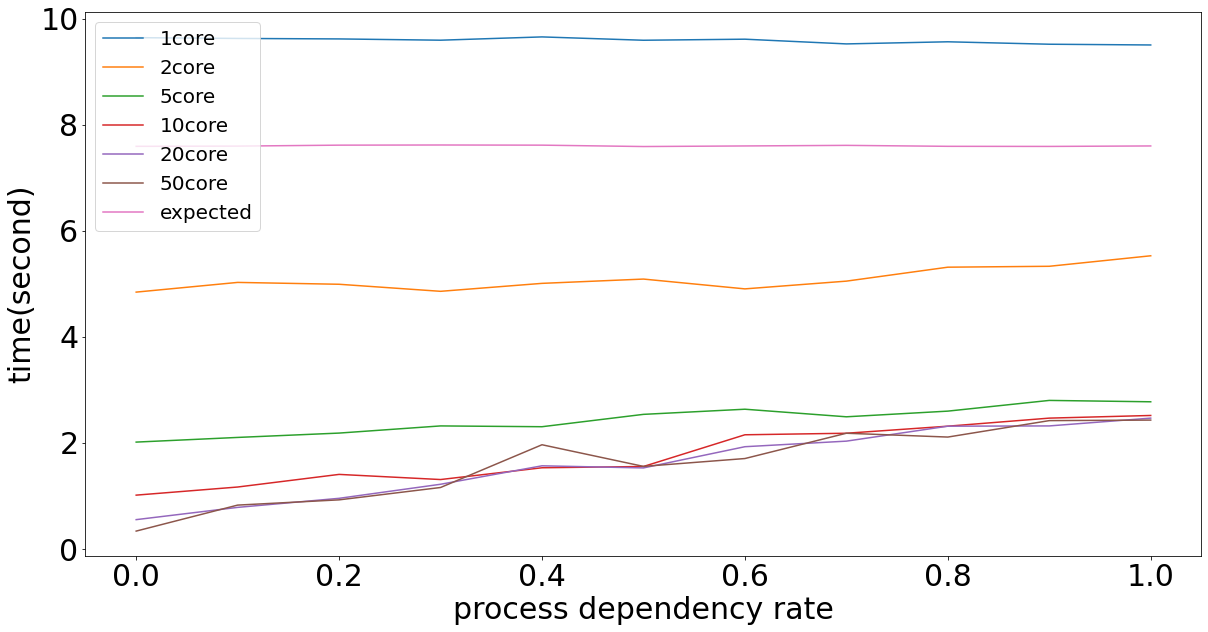

In [75]:
times = [[],[],[],[],[],[]]
probs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
expecteds = []
for prev_prob in probs:
    ex = []
    for i,core_count in enumerate([1,2,5,10,20,50]):
        tasks,expected = make_tasks(task_count=5,time_range=(90,100),prev_prob=prev_prob)
        cpu = CPU(core_count)
        times[i].append(cpu.run())
        ex.append(expected)
    expecteds.append(int(sum(ex)*1000/len(ex))*10**(-3))
    
df = pd.DataFrame({
    '1core':times[0],
    '2core':times[1],
    '5core':times[2],
    '10core':times[3],
    '20core':times[4],
    '50core':times[5],
    'prev_prob':probs,
    'expected':expecteds
})
display(df)
ax = df.set_index(df.prev_prob).drop('prev_prob',axis=1).plot(
    figsize=(20,10),
    fontsize=30)
ax.set_ylabel('time(second)',fontdict={'fontsize':30})
ax.set_xlabel('process dependency rate',fontdict={'fontsize':30})
plt.legend(loc=2, prop={'size': 20})
pass

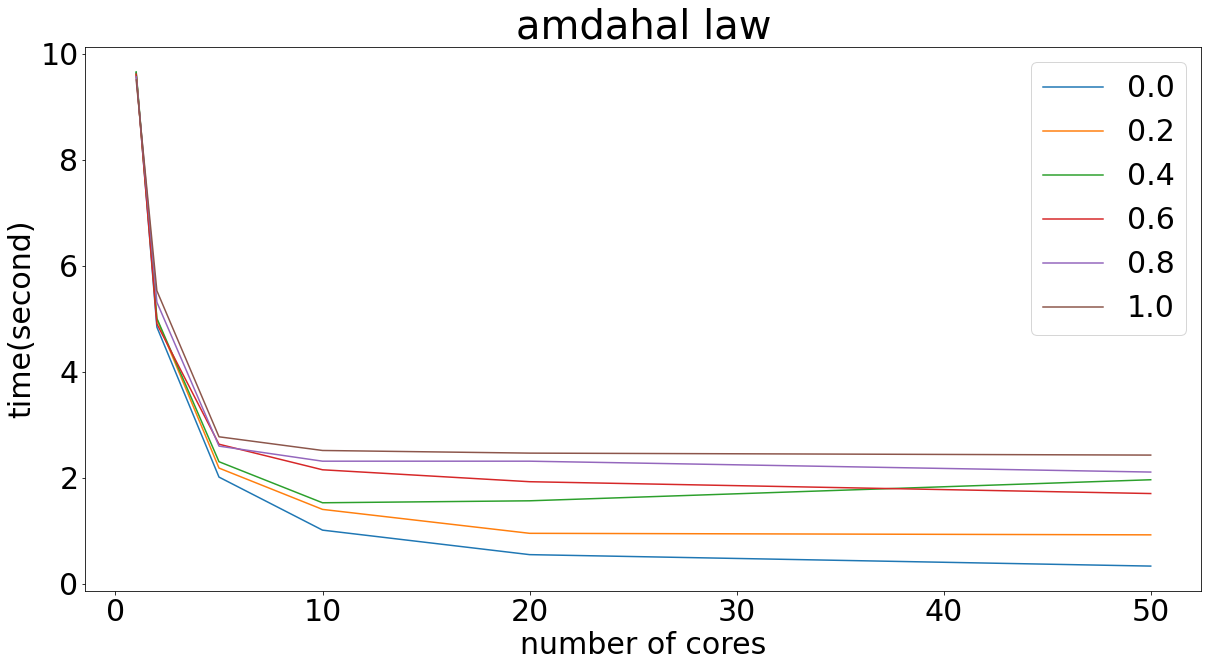

In [93]:
ax = pd.DataFrame(df.iloc[[0,2,4,6,8,10]].drop(['prev_prob','expected'],axis=1).to_numpy().T,
            columns = [0,0.2,0.4,0.6,0.8,1],index=[1,2,5,10,20,50]).plot(
                figsize=(20,10),
                fontsize=30,
                )
ax.set_ylabel('time(second)',fontdict={'fontsize':30})
ax.set_xlabel('number of cores',fontdict={'fontsize':30})
plt.legend(loc=1, prop={'size': 30})
plt.title('amdahal law',size=40)
pass